<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/SDXL/InstantID_sdxl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy insightface einops onnxruntime
! git clone https://github.com/InstantID/InstantID.git
! curl -Lo /content/models/antelopev2.zip https://drive.usercontent.google.com/open?id=18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8&authuser=0
! gdown 18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 44.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00
Cloning into 'Insta

In [2]:
%%shell
mkdir  /content/models
cd /content/models
unzip /content/antelopev2.zip

Archive:  /content/antelopev2.zip
   creating: antelopev2/
  inflating: antelopev2/genderage.onnx  
  inflating: antelopev2/2d106det.onnx  
  inflating: antelopev2/1k3d68.onnx  
  inflating: antelopev2/glintr100.onnx  
  inflating: antelopev2/scrfd_10g_bnkps.onnx  


In [7]:
import mediapy as media
import random
import sys
import torch
import gc
import time
import cv2

import cv2
import torch
import numpy as np
from PIL import Image

sys.path.insert(0,'/content/InstantID')

from insightface.app import FaceAnalysis
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline, draw_kps

from diffusers import AutoencoderKL, UniPCMultistepScheduler
from diffusers.models import ControlNetModel

from huggingface_hub import hf_hub_download


hf_hub_download(repo_id="InstantX/InstantID", filename="ControlNetModel/config.json", local_dir="./checkpoints")
hf_hub_download(repo_id="InstantX/InstantID", filename="ControlNetModel/diffusion_pytorch_model.safetensors", local_dir="./checkpoints")
hf_hub_download(repo_id="InstantX/InstantID", filename="ip-adapter.bin", local_dir="./checkpoints")


styles = {
"Enhance" : {
"Positive" : "breathtaking {prompt} . award-winning, professional, highly detailed",
"Negative" : "ugly, deformed, noisy, blurry, distorted, grainy",
},
"Anime" : {
"Positive" : "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
"Negative" : "photo, deformed, black and white, realism, disfigured, low contrast",
},
"Photographic" : {
"Positive" : "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
"Negative" : "drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly",
},
"Digital art" : {
"Positive" : "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
"Negative" : "photo, photorealistic, realism, ugly",
},
"Comic book" : {
"Positive" : "comic {prompt} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
"Negative" : "photograph, deformed, glitch, noisy, realistic, stock photo",
},
"Fantasy art" : {
"Positive" : "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy",
"Negative" : "photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white",
},
"Analog film" : {
"Positive" : "analog film photo {prompt} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Neonpunk" : {
"Positive" : "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Isometric" : {
"Positive" : "isometric style {prompt} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate",
"Negative" : "deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic",
},
"Lowpoly" : {
"Positive" : "low-poly style {prompt} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Origami" : {
"Positive" : "origami style {prompt} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Line art" : {
"Positive" : "line art drawing {prompt} . professional, sleek, modern, minimalist, graphic, line art, vector graphics",
"Negative" : "anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic",
},
"Craft clay" : {
"Positive" : "play-doh style {prompt} . sculpture, clay art, centered composition, Claymation",
"Negative" : "sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Cinematic" : {
"Positive" : "cinematic film still {prompt} . shallow depth of field, vignette, highly detailed, high budget Hollywood movie, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy",
"Negative" : "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured",
},
"3d-model" : {
"Positive" : "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
"Negative" : "ugly, deformed, noisy, low poly, blurry, painting",
},
"Pixel art" : {
"Positive" : "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
"Negative" : "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic",
},
"Texture" : {
"Positive" : "texture {prompt} top down close-up",
"Negative" : "ugly, deformed, noisy, blurry",
}
}

aspects = {
"12:5" :  { 'x' : 1536  , 'y' :  640 },
"7:4" :   { 'x' : 1344  , 'y' :  768 },
"19:13" : { 'x' : 1216  , 'y' :  832  },
"9:7" :   { 'x' : 1152 , 'y' : 896  },
"1:1" :   { 'x' : 1024 , 'y' : 1024 },
"7:9" :   { 'x' : 896  , 'y' : 1152  },
"13:19" : { 'x' : 832  , 'y' :  1216 },
"4:7" :   { 'x' : 768  , 'y' :  1344 },
"5:12" :  { 'x' : 640  , 'y' :  1536 }
}




In [6]:
#model_id = "ptx0/terminus-xl-gamma-v2"
#model_id = "stabilityai/stable-diffusion-xl-base-1.0"
#model_id = "dataautogpt3/OpenDalleV1.1"
model_id = "SG161222/RealVisXL_V3.0"
#model_id ="stablediffusionapi/zavychromaxl"

#ip_ckpt = "ip-adapter-faceid_sdxl.bin"
#image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"

# prepare 'antelopev2' under ./models
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# prepare models under ./checkpoints
face_adapter = f'./checkpoints/ip-adapter.bin'
controlnet_path = f'./checkpoints/ControlNetModel'

controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16,
                                    force_upcast=False).to('cuda')


pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    vae=vae,
    use_safetensors=True,
    variant="fp16",
    torch_dtype=torch.float16
)
pipe.to('cuda')


pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_vae_tiling()

# load adapter
pipe.load_ip_adapter_instantid(face_adapter)

pipe.set_ip_adapter_scale(0.8)



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The next cell is where you set you parameters and run Stable Diffusion.

The cell is re-runable, so you can edit the parameters and run without recreating the environment


  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Fantasy art
Seed:	1610628818184707569



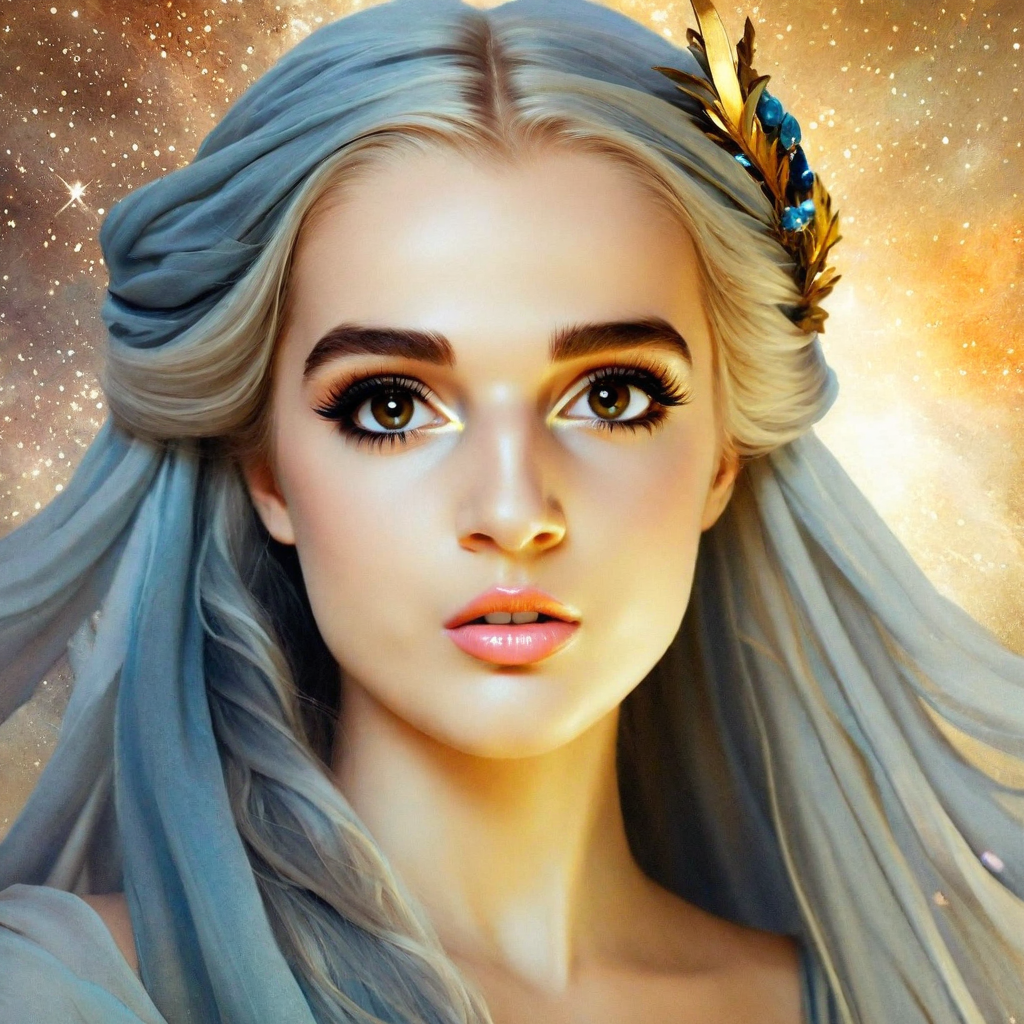

  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Fantasy art
Seed:	1179287016211666164



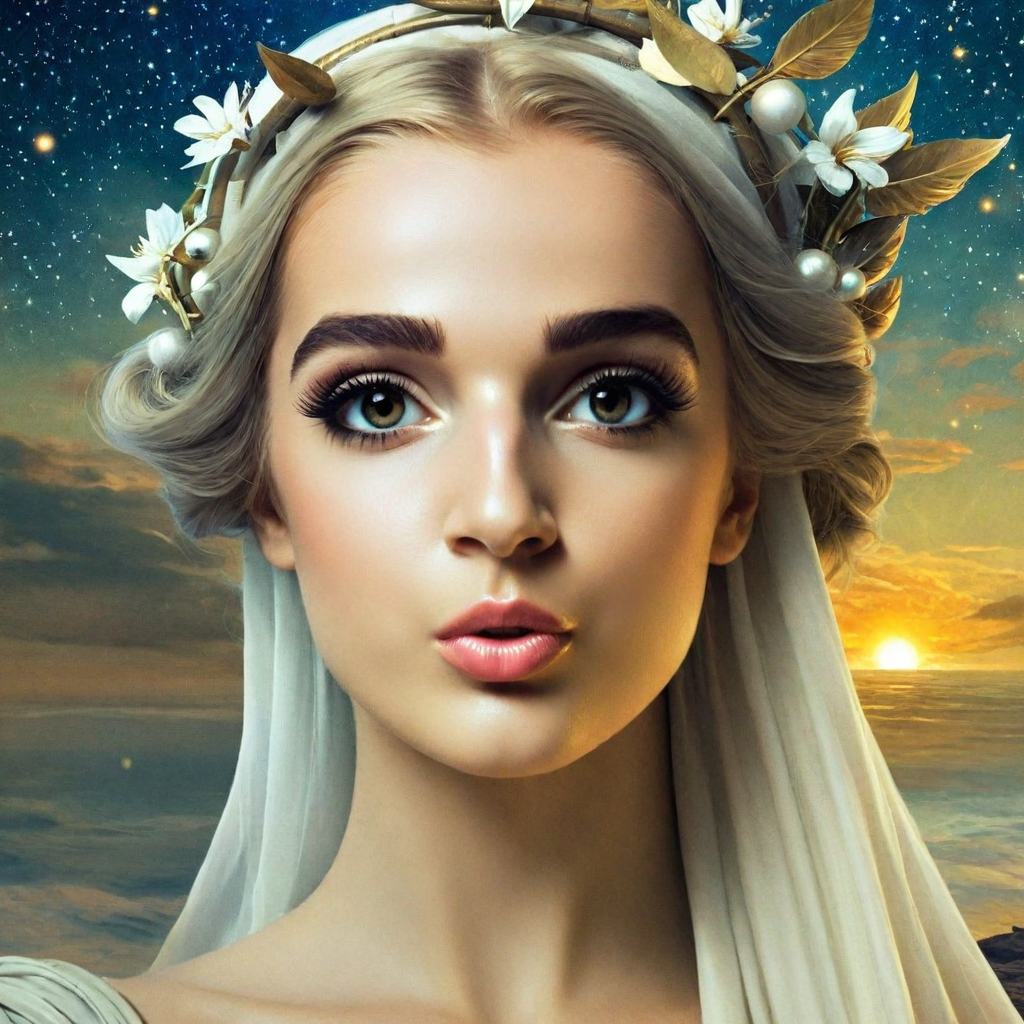

  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Fantasy art
Seed:	7457344469841075965



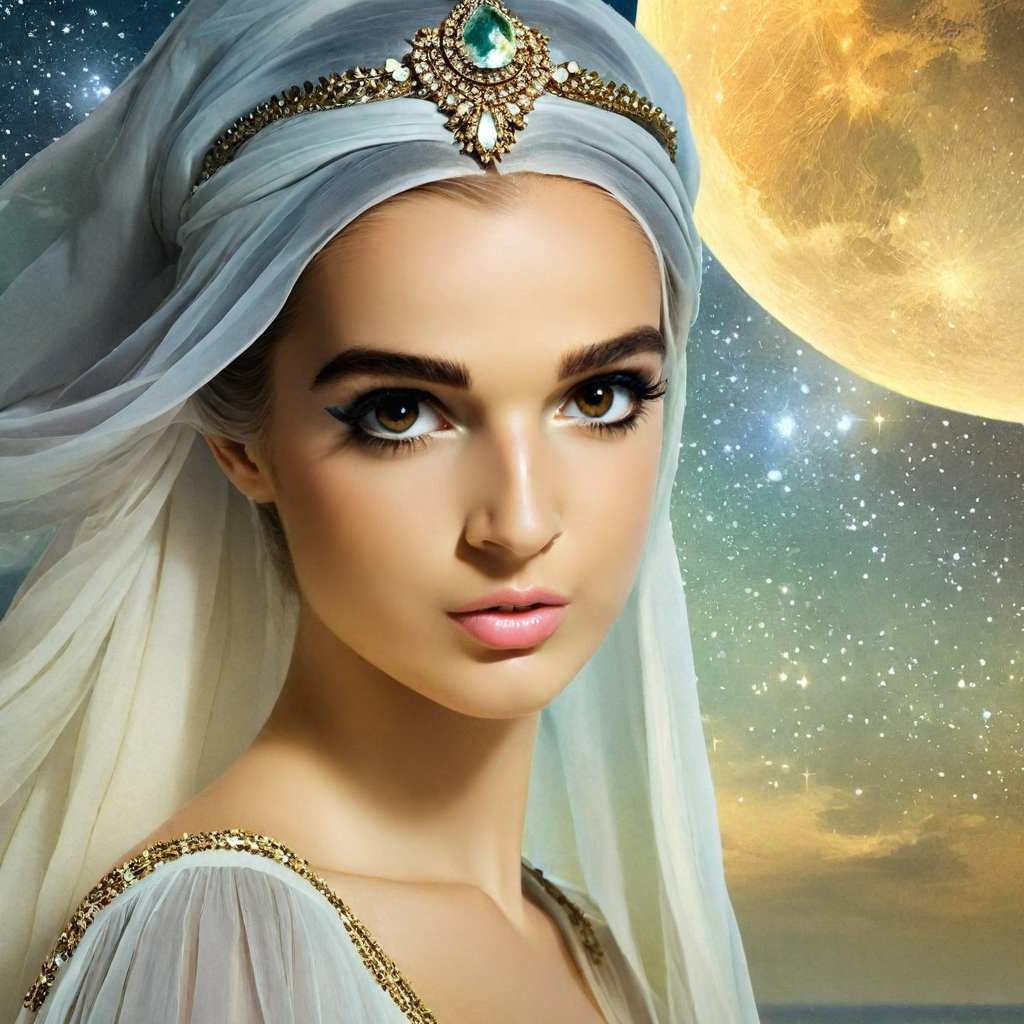

  0%|          | 0/45 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Fantasy art
Seed:	7402155258886735113



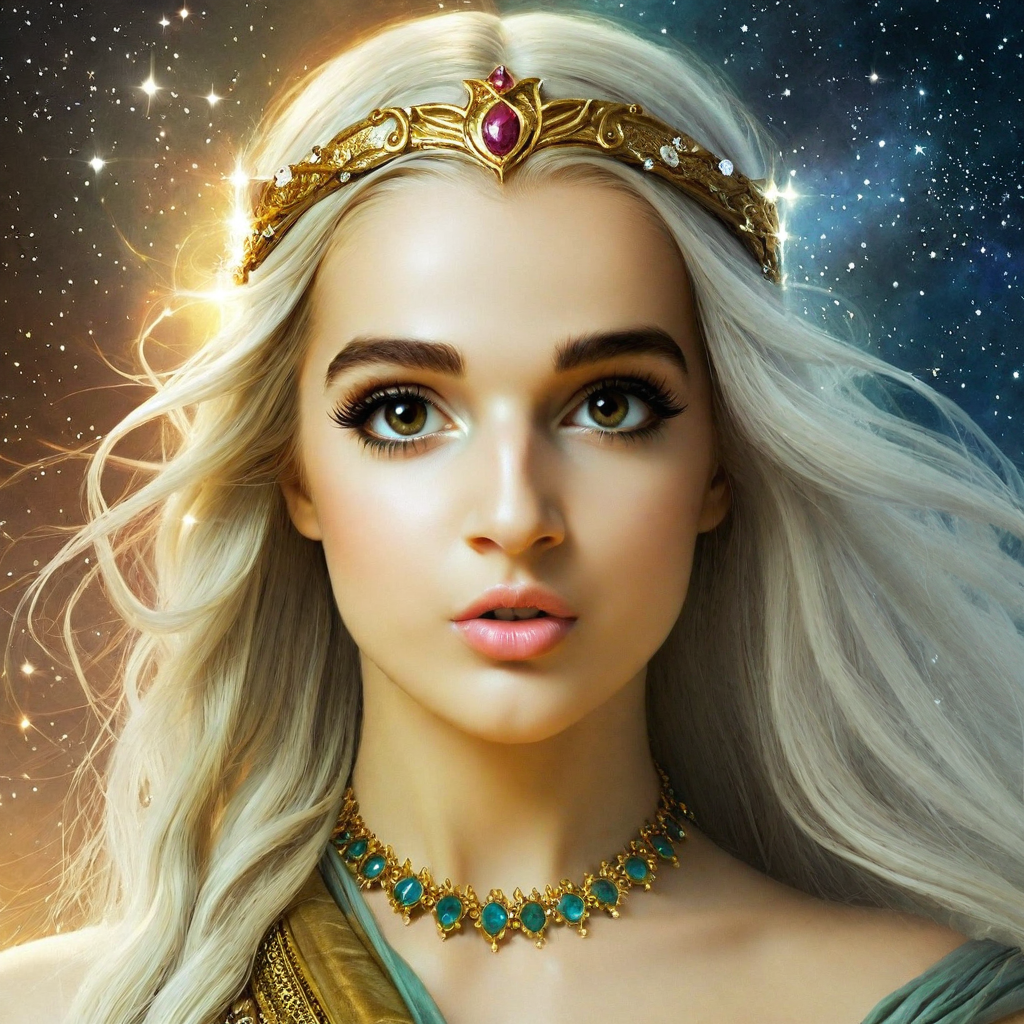

In [9]:
prompt = 'Nina Hagen as Sappho by Auguste Mengin'
prompt = 'A red haired woman standing in a lush green jungle'
prompt = 'A woman standing in a lush green jungle'
prompt = 'a Woman dressed as Sappho by Auguste Mengin'

image_count = 4
num_inference_steps=45
style = "Fantasy art"
aspect = "7:9"


face_image = Image.open("/content/phs3.jpg")

# prepare face emb
face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*x['bbox'][3]-x['bbox'][1])[-1] # only use the maximum face
face_emb = face_info['embedding']
face_kps = draw_kps(face_image, face_info['kps'])


orig_prompt = prompt
prompt = styles[style]["Positive"].replace("{prompt}", prompt)
negative_prompt = styles[style]["Negative"] + ", getty"

torch.cuda.empty_cache()


for i in range(image_count):

  seed = random.randint(0, sys.maxsize)



  image = pipe(
    prompt, negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    image_embeds=face_emb, image=face_kps, controlnet_conditioning_scale=0.8, guidence_scale=8,
    width=1024, height=1024
  ).images[0]

  print(f"Prompt:\t{orig_prompt}\nStyle:\t{style}\nSeed:\t{seed}")
  media.show_image(image)
